This Jupyter Notebook allows the user to explore how the time-of-flight of an ASAT impacts the geometry of the trajectory. 

First we need to load the python packages that will be used for this analysis. 

In [31]:
#load base packages
import numpy as np
import numpy.linalg as LA
import io
import json
import xml.etree.ElementTree as ET

#load astropy packages
from astropy import coordinates as coord
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, ITRS, TEME, GCRS

#Load poliastro packages
from poliastro.twobody import Orbit
from poliastro.core.iod import vallado
from poliastro.bodies import Earth, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.util import norm, time_range

#load packages to read from 18 SDS satcat through celestrak
import httpx
from sgp4 import exporter, omm
from sgp4.api import Satrec

#Load widge packages
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Now we need to define the variables that will characterize our engagement

In [32]:
#Load assumptions

#Launch Time
now = Time.now()

#Intercept Time of Flight
tof = 18*u.h
tof_name = "Post-apogee Intercept"

#Assump endgame starts 5 minutes before intercept
#this should probably be an acquisition range not a time **shrug**
t_end = tof-5*u.min

#Future assumption on CTS at endgame for intercept

#Future assumption for max closing rate at endgame

#Xichang Satellite Launch Center Longitutde and Latitude (Zeyuan Town)
asat_lon = 102.026556*u.deg
asat_lat = 28.246017*u.deg
#looked this up on https://www.calcmaps.com/map-elevation/
asat_alt = 1846*u.m
asat_loc_name = "Xichang Satellite Launch Center"

#target_name must be the name of a satellite in the SATCAT
target_name = "AEHF-4 (USA 288)"
#target_name = "AEHF-6 (USA 298)"

#example LEO target
#target_name = "ISS (ZARYA)"

#example HEO target
#target_name = "COSMOS 2552"

In [33]:
#convert asat launch site lat/lon to GCRS
asat_site = coord.EarthLocation(asat_lon, asat_lat, asat_alt)

#use astropy library to transform from lat/lon to gcrs
gcrs = asat_site.get_gcrs(obstime=now)

#extract cartesian position
r_asat_L = gcrs.cartesian.xyz<<u.km

#extract velocity at site
v_asat_L = gcrs.velocity.d_xyz# These are the functions necessary for reading TLEs from Celestrak
# From https://github.com/poliastro/poliastro/blob/main/contrib/satgpio.py

def _generate_url(catalog_number, international_designator, name):
    params = {"CATNR": catalog_number, "INTDES": international_designator, "NAME": name}
    param_names = [
        param_name
        for param_name, param_value in params.items()
        if param_value is not None
    ]
    if len(param_names) != 1:
        raise ValueError(
            "Specify exactly one of catalog_number, international_designator, or name"
        )
    param_name = param_names[0]
    param_value = params[param_name]
    url = (
        "https://celestrak.com/NORAD/elements/gp.php?"
        f"{param_name}={param_value}"
        "&FORMAT=XML"
    )
    return url

def _segments_from_query(url):
    response = httpx.get(url)
    response.raise_for_status()

    if response.text == "No GP data found":
        raise ValueError(
            f"Query '{url}' did not return any results, try a different one"
        )
    tree = ET.parse(io.StringIO(response.text))
    root = tree.getroot()

    yield from omm.parse_xml(io.StringIO(response.text))

def load_gp_from_celestrak(
    *, catalog_number=None, international_designator=None, name=None
):
    """Load general perturbations orbital data from Celestrak.

    Returns
    -------
    Satrec
        Orbital data from specified object.

    Notes
    -----
    This uses the OMM XML format from Celestrak as described in [1]_.

    References
    ----------
    .. [1] Kelso, T.S. "A New Way to Obtain GP Data (aka TLEs)"
       https://celestrak.com/NORAD/documentation/gp-data-formats.php

    """
    # Assemble query, raise an error if malformed
    url = _generate_url(catalog_number, international_designator, name)

    # Make API call, raise an error if data is malformed
    for segment in _segments_from_query(url):
        # Initialize and return Satrec object
        sat = Satrec()
        omm.initialize(sat, segment)

        yield sat

def print_sat(sat, name):
    """Prints Satrec object in convenient form."""
    print(json.dumps(exporter.export_omm(sat, name), indent=2))

In [34]:
#load target from SATCAT
#tutorial for this section is here: https://docs.poliastro.space/en/stable/examples/Loading%20OMM%20and%20TLE%20satellite%20data.html
target = list(load_gp_from_celestrak(name=target_name))[0]

In [35]:
#import graphing package
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#define a font to set a large plot size
def scale_plot_size(factor=1.5):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor

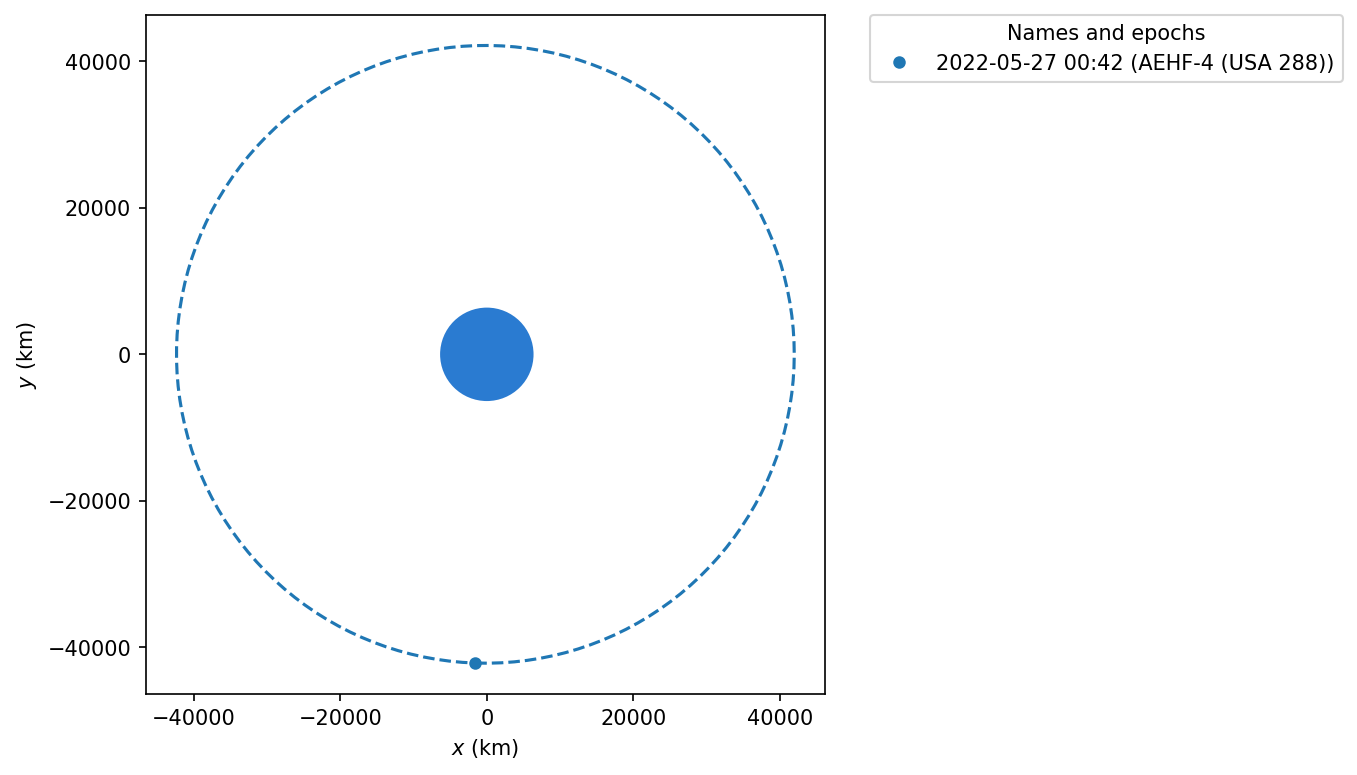

In [36]:
#expand window
scale_plot_size(factor=1.5)

#get r and v of target at now
error, r, v = target.sgp4(now.jd1, now.jd2)
teme = TEME(r, obstime=now)

gcrs = GCRS(obstime=now)
r = teme.transform_to(gcrs).cartesian
r.xyz*u.km

target_orb = Orbit.from_vectors(Earth, r.xyz*u.km, v*u.km/u.s, epoch=now)
target_orb.plot(label = target_name)

In [42]:
def shoot(tof):

    tof = tof * u.h
    
    #Propagate target orbit to impact time
    target_orb_impact = target_orb.propagate(tof)
    print ("Target position at impact is: ",target_orb_impact.r)
    
    #Solve Lamberet Problem where r0 is ASAT launch site and R1 is impact position
    k = Earth.k.to(u.km ** 3 / u.s ** 2)
    r0 = r_asat_L
    r1 = target_orb_impact.r

    v1, v2 = vallado(k.value, r0, r1, tof*60*60, short=True, numiter=100, rtol=1e-8)
    
    #create ASAT Orbit
    scale_plot_size(factor=1.5)
    asat_orb = Orbit.from_vectors(Earth, r0, v1*u.km/u.s, epoch=now)
    
    #calculate the delta-V required for the intercept
    total_deltav = LA.norm(v1- v_asat_L.value)*u.km/u.s
    
    #calculate camerata-target-sun

    #propagate orbits to endgame
    asat_end = asat_orb.propagate(t_end)
    target_end = target_orb.propagate(t_end)

    #vectors for asat interceptor (i) and target (t)
    r_i = asat_end.r
    v_i = asat_end.v
    r_t = target_end.r
    v_t = target_end.v

    #use astropy to get the sun position at now+t_end
    sun = coord.get_sun(now+t_end)
    r_sun = sun.cartesian.xyz<<u.km

    #calulate the target-to-sun position vector and 
    #target-to-interceptor position vector
    t2sun = r_sun - r_t
    t2i = r_i - r_t

    def vec_angle(a,b):
        inner = np.inner(a,b)
        norms = LA.norm(a)*LA.norm(b)
        cos = inner/norms
        rad = np.arccos(np.clip(cos, -1.0, 1.0))
        deg = np.rad2deg(rad)
        return deg

    cts_end = vec_angle(t2sun, t2i)

    def GCRS_to_RIC(rt, vt, ri, vi):
        #rt and vt is the center of the new RIC reference frame

        r_units = rt.unit
        v_units = vt.unit

        rt = rt.value
        vt = vt.value
        ri = ri.value
        vi = vi.value

        R_hat = rt/LA.norm(rt)
        I_hat = vt/LA.norm(vt)
        C_cross = np.cross(R_hat, I_hat)
        C_hat = C_cross/LA.norm(C_cross)
        r = ri - rt
        v = vi - vt
        rRIC = [np.dot(r, R_hat), np.dot(r, I_hat), np.dot(r, C_hat)]
        vRIC = [np.dot(v, R_hat), np.dot(v, I_hat), np.dot(v, C_hat)]
        return rRIC*r_units, vRIC*v_units

    rRIC, vRIC = GCRS_to_RIC(r_t, v_t, r_i, v_i)
    closing_speed = LA.norm(vRIC)

    #let poliastro do its magic
    from poliastro.plotting import StaticOrbitPlotter
    from matplotlib import pyplot as plt
    scale_plot_size(factor=1.5)
    
    #calculate asat and target ephemeris during the tof
    epochs = time_range(now, end=now+tof)
    asat_e = Ephem.from_orbit(asat_orb, epochs, plane=Planes.EARTH_EQUATOR)
    target_e = Ephem.from_orbit(target_orb, epochs, plane=Planes.EARTH_EQUATOR)
    
    fig, ax = plt.subplots()
    ax.set_title(tof_name+" ASAT Trajectory")
    frame = StaticOrbitPlotter(ax, plane=Planes.EARTH_EQUATOR)
    frame.plot(target_orb, label="Target at L = 0")
    frame.plot(asat_orb, label="ASAT at L = 0", color="red")
    frame.plot_ephem(asat_e, label="ASAT Trajectory", color="red")
    frame.plot_ephem(target_e, label="Target Trajectory", color="blue")

    caption_text = "ASAT Time of Flight = "+str(tof)+"\n\nTarget: "+target_name+"\n\n"+"From: "+asat_loc_name+"\n\nLaunch Vehicle Delta-V: "+str(np.around(total_deltav,2))+"\n\nClosing Speed: "+str(np.around(closing_speed,2))
    caption = plt.figtext(.74, .15, caption_text, wrap=True, horizontalalignment='center', fontsize=9)
    caption.set_bbox(dict(facecolor='pink', alpha=1))

In [43]:
interact(shoot, tof=widgets.IntSlider(min=2, max=24, step=1, value=5.15));

interactive(children=(IntSlider(value=5, description='tof', max=24, min=2), Output()), _dom_classes=('widget-i…